In [1]:
'''
Created on Nov 18, 2017

Pool the pileup files generated for epigenomes E001 - E129. This script is for DNase-seq, and will be adapted for the RNA-seq
pileups.
'''
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)

suffix = "_pileupOn_hg19.refSeqTSSs.pm500bp.txt" # only pick pileups files with this suffix
dir_pileups = "/data/gordanlab/dinesh/predicting_gex/Output/roadmap_signal/rnase_imputed" 
csv_eid_info = "/data/gordanlab/dinesh/predicting_gex/Input_files/roadmap/roadmap_EID_info.txt"
outputDir = dir_pileups  # IMPORTANT that the pooled file is named properly (eg. "E119-RNAseq.imputed.LogRPKM.signal")
output_fileName = "roadmap.rnase_imputed.LogRPKM.signal.txt"

In [2]:
'''get df with EID info'''
df_eid_info = pd.read_csv(csv_eid_info, sep="\t", index_col=0)
print(df_eid_info.shape)
df_eid_info.head(2)

(127, 4)


,Standardized Epigenome name,Epigenome Mnemonic,GROUP,EID_info
Epigenome ID (EID),,,,
E017,IMR90 fetal lung fibroblasts Cell Line,LNG.IMR90,IMR90,E017_LNG.IMR90_IMR90
E002,ES-WA7 Cells,ESC.WA7,ESC,E002_ESC.WA7_ESC


In [3]:
def get_eid_sample_name(acsv_pileup):
    # acsv_pileup is the input filename of this format: 
    # 'E129-RNAseq.imputed.LogRPKM.signal_pileupOn_hg19.refSeqTSSs.pm500bp.txt'
    eid = re.split("\.", acsv_pileup)[0]  # returns, for eg. E129-RNA-seq
    eid = re.split("-", eid)[0]
    sample_name = df_eid_info.loc[eid]["EID_info"]  # returns, for eg. 'E017_LNG.IMR90_IMR90'
    return sample_name

In [4]:
csvs_pileup = sorted([x for x in os.listdir(dir_pileups) if (x.__contains__(suffix))])

In [5]:
'''collect and merge the signal files to a df'''
dfs = []
for acsv_pileup in csvs_pileup:
    df = pd.read_csv(os.path.join(dir_pileups, acsv_pileup), sep="\t", header=None, names=["chrom", "ss", "es", "geneName", get_eid_sample_name(acsv_pileup)])  
    dfs.append(df)

df_pileup_pooled = dfs[0]
for i in range(1, len(dfs)):
    df_pileup_pooled = pd.merge(df_pileup_pooled, dfs[i], on=['chrom', 'ss', 'es', 'geneName'])

In [6]:
df_pileup_pooled.head(3)

,chrom,ss,es,geneName,E001_ESC.I3_ESC,E002_ESC.WA7_ESC,E003_ESC.H1_ESC,E004_ESDR.H1.BMP4.MESO_ES-deriv,E005_ESDR.H1.BMP4.TROP_ES-deriv,E006_ESDR.H1.MSC_ES-deriv,...,E120_MUS.HSMM_ENCODE2012,E121_MUS.HSMMT_ENCODE2012,E122_VAS.HUVEC_ENCODE2012,E123_BLD.K562.CNCR_ENCODE2012,E124_BLD.CD14.MONO_ENCODE2012,E125_BRN.NHA_ENCODE2012,E126_SKIN.NHDFAD_ENCODE2012,E127_SKIN.NHEK_ENCODE2012,E128_LNG.NHLF_ENCODE2012,E129_BONE.OSTEO_ENCODE2012
0,chr1,11373,12373,DDX11L1,80.15,103.55,109.86,66.88,115.07,105.42,...,88.75,101.48,105.50,212.38,300.45,81.02,91.73,98.23,124.92,88.48
1,chr1,16936,17936,MIR6859-2,2119.40,2169.75,2226.48,2136.81,2574.41,2439.35,...,2230.61,2041.39,2249.71,2783.41,3069.73,2173.70,2248.84,2402.39,2787.36,2168.68
2,chr1,28870,29870,WASH7P,353.00,436.45,427.10,342.95,352.85,322.60,...,316.50,275.80,311.40,346.30,385.75,313.15,301.25,334.80,333.45,287.70


In [7]:
'''Add locs as indices'''
loc = ["{}:{}-{}".format(x[0], str(x[1]), str(x[2])) for x in zip(df_pileup_pooled["chrom"], df_pileup_pooled["ss"], df_pileup_pooled["es"])]  
df_pileup_pooled["loc"] = loc
df_pileup_pooled = df_pileup_pooled.set_index(["geneName", "loc"])

'''Dropping the chrom, ss, es fields'''
df_pileup_pooled = df_pileup_pooled.drop(["chrom", "ss", "es"], axis=1)

In [8]:
'''Reorder the samples so that those in the same group are together.'''
df_pileup_pooled = df_pileup_pooled[df_eid_info["EID_info"].tolist()]

In [9]:
df_pileup_pooled.head(3)

,,E017_LNG.IMR90_IMR90,E002_ESC.WA7_ESC,E008_ESC.H9_ESC,E001_ESC.I3_ESC,E015_ESC.HUES6_ESC,E014_ESC.HUES48_ESC,E016_ESC.HUES64_ESC,E003_ESC.H1_ESC,E024_ESC.4STAR_ESC,E020_IPSC.20B_iPSC,...,E120_MUS.HSMM_ENCODE2012,E121_MUS.HSMMT_ENCODE2012,E122_VAS.HUVEC_ENCODE2012,E123_BLD.K562.CNCR_ENCODE2012,E124_BLD.CD14.MONO_ENCODE2012,E125_BRN.NHA_ENCODE2012,E126_SKIN.NHDFAD_ENCODE2012,E127_SKIN.NHEK_ENCODE2012,E128_LNG.NHLF_ENCODE2012,E129_BONE.OSTEO_ENCODE2012
geneName,loc,,,,,,,,,,,,,,,,,,,,,
DDX11L1,chr1:11373-12373,112.19,103.55,83.26,80.15,76.86,65.11,106.22,109.86,82.30,81.86,...,88.75,101.48,105.50,212.38,300.45,81.02,91.73,98.23,124.92,88.48
MIR6859-2,chr1:16936-17936,2423.37,2169.75,2051.70,2119.40,2058.41,2070.94,2215.21,2226.48,2173.17,2114.16,...,2230.61,2041.39,2249.71,2783.41,3069.73,2173.70,2248.84,2402.39,2787.36,2168.68
WASH7P,chr1:28870-29870,300.15,436.45,395.85,353.00,383.25,385.55,332.05,427.10,368.00,382.50,...,316.50,275.80,311.40,346.30,385.75,313.15,301.25,334.80,333.45,287.70


In [10]:
'''save the df'''
df_pileup_pooled.to_csv(os.path.join(outputDir, output_fileName), header=True, sep="\t")

### Now summarize the df and look at the overall + gene-specific expression profiles for these samples

In [11]:
df_pileup_pooled.describe()

,E017_LNG.IMR90_IMR90,E002_ESC.WA7_ESC,E008_ESC.H9_ESC,E001_ESC.I3_ESC,E015_ESC.HUES6_ESC,E014_ESC.HUES48_ESC,E016_ESC.HUES64_ESC,E003_ESC.H1_ESC,E024_ESC.4STAR_ESC,E020_IPSC.20B_iPSC,...,E120_MUS.HSMM_ENCODE2012,E121_MUS.HSMMT_ENCODE2012,E122_VAS.HUVEC_ENCODE2012,E123_BLD.K562.CNCR_ENCODE2012,E124_BLD.CD14.MONO_ENCODE2012,E125_BRN.NHA_ENCODE2012,E126_SKIN.NHDFAD_ENCODE2012,E127_SKIN.NHEK_ENCODE2012,E128_LNG.NHLF_ENCODE2012,E129_BONE.OSTEO_ENCODE2012
count,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000,...,27544.000000,27544.000000,27544.000000,27544.000000,27544.00000,27544.000000,27544.000000,27544.000000,27544.000000,27544.000000
mean,604.298701,676.360487,697.913045,696.576134,717.516724,713.805839,681.657764,719.062333,680.574802,708.367466,...,567.424844,578.897521,586.469339,631.165152,685.55105,586.674169,564.886422,613.782474,639.617285,578.376455
std,719.632634,769.854555,800.462692,791.670043,829.666319,829.644051,785.919830,810.883052,780.900250,827.841083,...,695.743972,681.366448,696.401959,744.205758,791.99882,701.853378,691.224445,747.560784,764.696466,698.677280
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.810000,0.000000
25%,63.500000,103.452500,94.197500,96.617500,82.125000,78.865000,84.515000,101.725000,86.810000,77.445000,...,46.410000,69.357500,64.717500,78.372500,86.28750,58.490000,52.500000,53.550000,65.657500,51.040000
50%,357.485000,408.725000,424.345000,432.110000,435.085000,428.370000,422.240000,445.840000,425.000000,421.460000,...,322.485000,345.740000,351.140000,390.100000,432.38500,341.305000,317.820000,340.115000,363.165000,338.190000
75%,903.687500,993.297500,1038.005000,1035.675000,1083.625000,1078.287500,1015.532500,1077.107500,1012.792500,1068.685000,...,852.575000,865.072500,877.880000,933.427500,1016.58500,881.315000,849.455000,930.987500,962.842500,874.097500
max,8043.550000,7549.500000,8025.190000,7498.500000,7845.480000,7854.240000,8143.110000,7652.440000,7816.200000,7693.220000,...,8235.240000,8128.870000,8035.140000,7818.740000,8300.72000,8224.220000,8231.270000,8113.060000,7673.360000,8303.180000


In [12]:
def plot_signal(sampleName):
    sns.kdeplot(np.log2(df_pileup_pooled[sampleName]))
    plt.xlabel("log2 ({} signal)".format(sampleName))
    plt.ylabel("Density")

/gpfs/fs0/data/gordanlab/dinesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


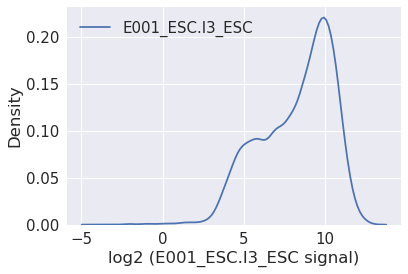

In [13]:
plot_signal("E001_ESC.I3_ESC")

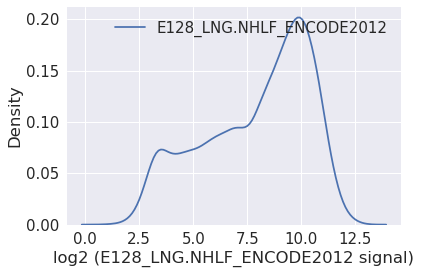

In [14]:
plot_signal("E128_LNG.NHLF_ENCODE2012")

/gpfs/fs0/data/gordanlab/dinesh/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


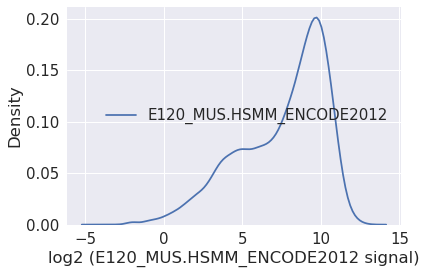

In [15]:
plot_signal("E120_MUS.HSMM_ENCODE2012")

In [89]:
'''Some of these are obtained form Becht2016, Table S2 (https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-1070-5) - see Florians email'''
esc_genes = ["TRA-1-60", "SSEA-4", "SSEA4", "OCT3", "OTF4", "OCT4", "SOX2", "NANOG", "KLF4", "FUT4"] # oct4 and pou5f1 are aliases
mus_genes = ["MYOD1", "ITGA7", "CDH15", "MYOG", "TNNT1", "DES", "TNNC1", "MYBPH", "MYLPF", "CKM", "LDB3", "TNNC2"] 
fib_genes = "ADAMTS2,ANGPTL2,C1R,C1S,CCDC80,CD248,CEMIP,CNN1,CNTN3,COL12A1,COL1A1,COL3A1,COL6A1,COL6A2,COPZ2,CREB3L1,DCN,EFEMP2,ELN,FBLN1,FBLN5,FGF7,FIBIN,GLT8D2,GREM1,GREM2,HSPB6,HSPB7,IGFBP5,ITGA11,KRTAP1-5,LOX,LPAR1,LRRN4CL,MASP1,MFGE8,MTSS1L,MXRA8,MYL9,PAMR1,PARVA,PCDH18,PDGFRA,PDGFRB,PLAC9,PLXNA3,PODN,PPP1R3C,PRR16,PRRX2,RGMB,SCARF2,STC2,SVEP1,TAGLN,THY1,TMEM119,TNFRSF11B,VASN,VGLL3,WISP1"
fib_genes = re.split(",", fib_genes)
endothelial_genes = re.split(",", "ACVRL1,ADAMTS18,ADGRF5,ADGRL4,ALPK3,ANGPT2,APLN,ARHGEF15,BCL6B,BMP6,BMX,C10orf10,CDH5,CLDN5,CLEC14A,CXorf36,DOCK6,DOCK9,ECSCR,EDN1,EFEMP1,EGFL7,ELK3,EMCN,ENG,EPHB4,ERG,ESAM,ESM1,EXOC6,FAM124B,FAM43A,FAM69B,FGD5,FLT4,FRY,FZD4,GNG11,GPR4,HECW2,HHIP,HOXD1,HYAL2,IPO11,KDR,KIAA1324L,KLHL4,LDB2,MMRN1,MMRN2,MTUS1,MYCT1,NOX4,PALMD,PEAR1,PGF,PLXNA2,PTPRB,RAMP2,RASIP1,RGS3,RHOB,RHOJ,ROBO4,SDPR,SEMA3F,SH3D19,SHANK3,SHE,SHROOM4,SNCA,SORBS2,SOX17,SOX18,SOX7,TEAD2,TEK,TFPI,TGFBR2,TGM2,TIE1,TMEM255B,TXNRD2,VEPH1,VWF") 
tcell_genes = re.split(",", "CD28,CD3D,CD3G,CD5,CD6,CTLA4,FLT3LG,ICOS,MAL,PBX4,SIRPG,THEMIS,TNFRSF25,TRAT1")
dendritic_genes = re.split(",", "CD1A,CD1B,CD1E,CLEC10A,CLIC2")
nk_genes = re.split(",", "CD160,KIR2DL1,KIR2DL3,KIR2DL4,KIR3DL1,KIR3DL2,NCR1,PTGDR,SH2D1B")
neuro_genes = ["ASCL1", "NEUROD2", "NEUROD1"]

In [90]:
genes_to_plot = esc_genes + mus_genes + tcell_genes + neuro_genes# + dendritic_genes
print("Plotting altogether {} genes.".format(len(genes_to_plot)))
df_genes_to_plot = df_pileup_pooled.iloc[df_pileup_pooled.index.get_level_values("geneName").isin(genes_to_plot)]

'''Reorder the genes in the df to be as'''
df_genes_to_plot = df_genes_to_plot.reindex(genes_to_plot, level='geneName')

Plotting altogether 39 genes.


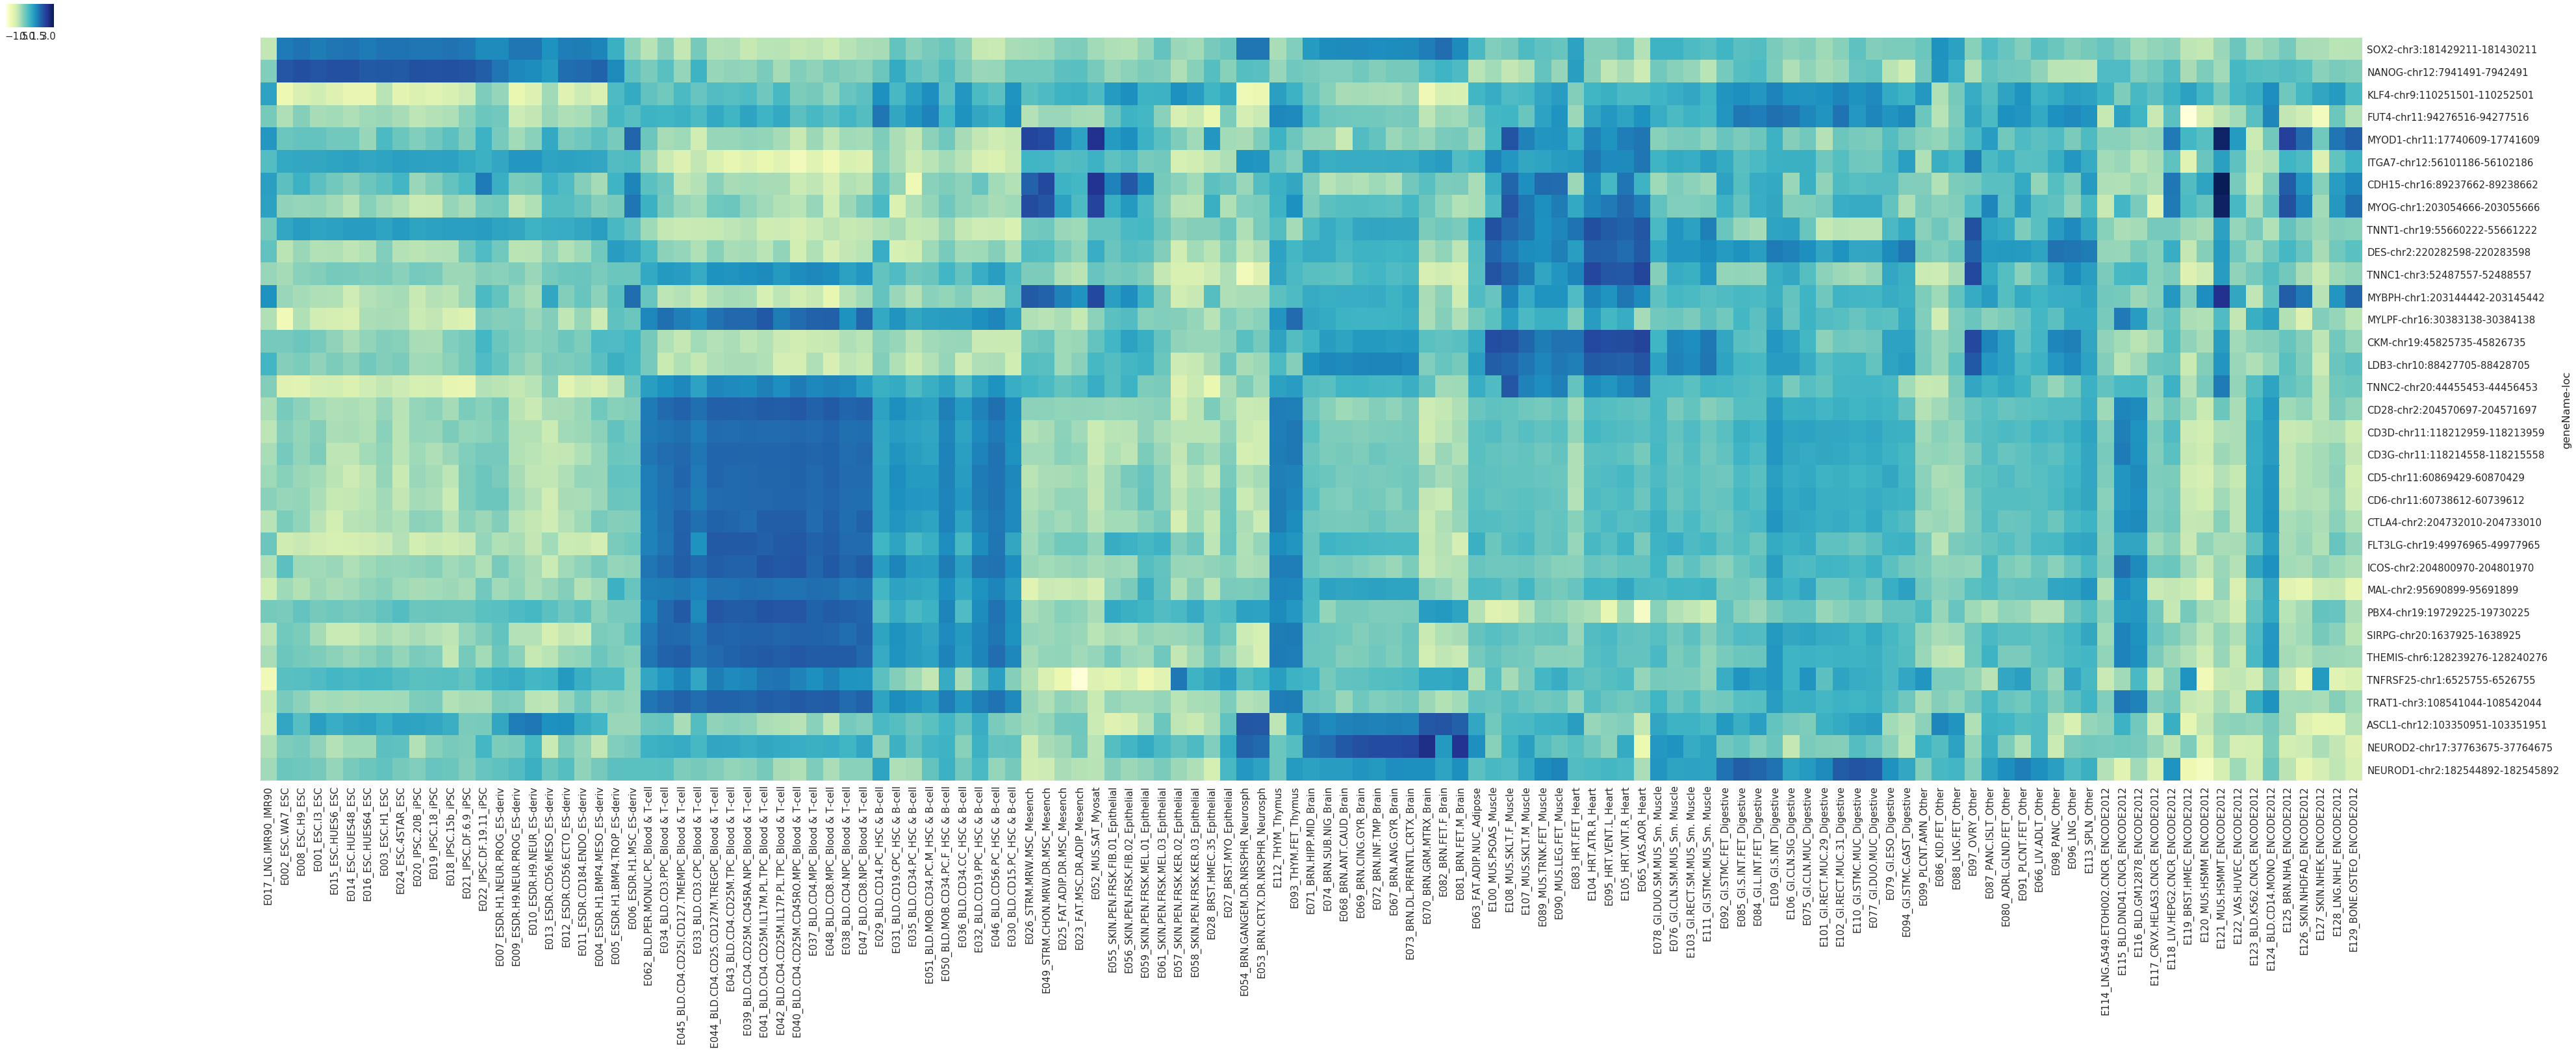

In [96]:
f = sns.clustermap(np.log2(df_genes_to_plot), col_cluster=False, row_cluster=False, z_score=0, cmap="YlGnBu", 
               figsize=(65,22), cbar_kws={"orientation": "horizontal"})
f.savefig("roadmap_gex_clustermap_wSome_marker_genes.pdf")